In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("/tmp/data",one_hot=True)


Extracting /tmp/data\train-images-idx3-ubyte.gz
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


In [3]:
img_dimension=28
flattened_size=img_dimension*img_dimension
X=tf.placeholder(tf.float32,shape=[None,flattened_size])


In [4]:
def create_weights(shape,name):
    weights=tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(weights,name=name)

    
    

In [5]:
def create_biases(shape,name):
    bias=tf.zeros(shape)
    return tf.Variable(bias,name=name)

In [6]:
def create_FClayer(X,weight,bias):
    return tf.matmul(X,weight)+bias

In [7]:
latent_dim=20
hidden_dim=500
w_1=create_weights(shape=[flattened_size,hidden_dim],name='w_1')
b_1=create_biases(shape=[hidden_dim],name='b_1')
hidden_layer=tf.nn.tanh(create_FClayer(X,w_1,b_1))

w_mean=create_weights(shape=[hidden_dim,latent_dim],name='w_mean')
b_mean=create_weights(shape=[latent_dim],name='b_mean')
mean=create_FClayer(hidden_layer,w_mean,b_mean)

w_logstd=create_weights(shape=[hidden_dim,latent_dim],name='w_logstd')
b_logstd=create_weights(shape=[latent_dim],name='b_logstd')
logstd=create_FClayer(hidden_layer,w_logstd,b_logstd)

noise=tf.random_normal(shape=[1,latent_dim])

z=mean+tf.multiply(tf.exp(0.5*logstd),noise)


In [8]:
np.shape(mnist)

(3,)

In [9]:
#decoder
w_2=create_weights(shape=[latent_dim,hidden_dim],name='w_2')
b_2=create_biases(shape=[hidden_dim],name='b_2')
hidden_layer_2=tf.nn.tanh(create_FClayer(z,w_2,b_2))

w_3=create_weights(shape=[hidden_dim,flattened_size],name='w_3')
b_3=create_weights(shape=[flattened_size],name='b_3')
reconstruction=tf.nn.sigmoid(create_FClayer(hidden_layer_2,w_3,b_3))



In [10]:
log_likelihood=tf.reduce_sum(X*tf.log(reconstruction+1e-9)+(1-X)*tf.log(1-reconstruction+1e-9),reduction_indices=1)
KL_term=-0.5*tf.reduce_sum(1+2*logstd-tf.square(mean)-tf.exp(2*logstd),reduction_indices=1)
variational_lower_bound=tf.reduce_mean(log_likelihood-KL_term)
optimizer=tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)


In [11]:

init=tf.global_variables_initializer()
sess=tf.InteractiveSession()
sess.run(init)
saver=tf.train.Saver()

iterations=100000
recording_interval=1000
variational_lower_bound_array=[]
log_likelihood_array=[]
KL_term_array=[]
iteration_array = [i*recording_interval for i in range(iterations//recording_interval)]
for i in range(iterations):
    x_batch=np.round(mnist.train.next_batch(200)[0])
    sess.run(optimizer,feed_dict={X:x_batch})
    if (i%recording_interval == 0):
        #every 1K iterations record these values
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print ("Iteration: {}, Loss: {}".format(i, vlb_eval))
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

Iteration: 0, Loss: -738.56005859375


KeyboardInterrupt: 

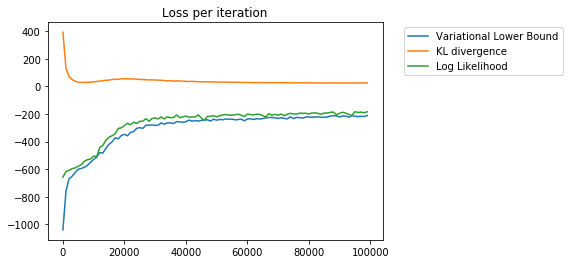

In [41]:
plt.figure()
#for the number of iterations we had 
#plot these 3 terms
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

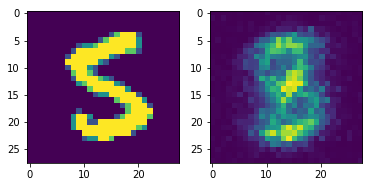

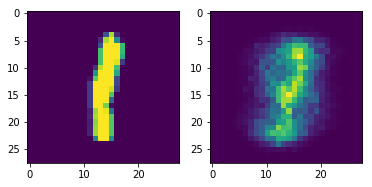

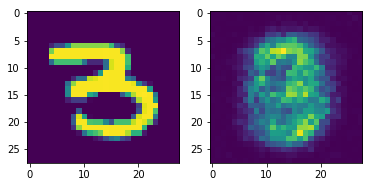

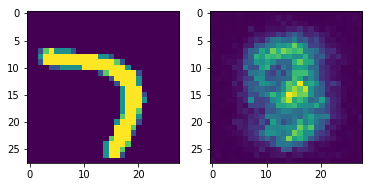

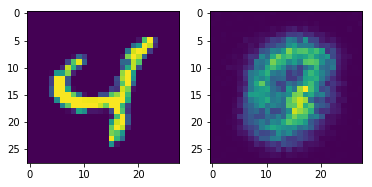

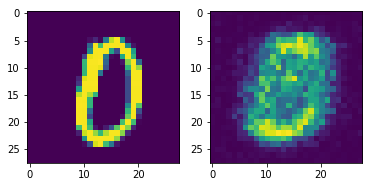

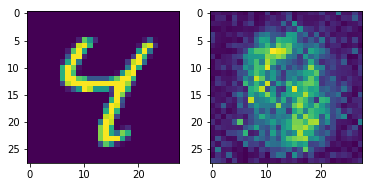

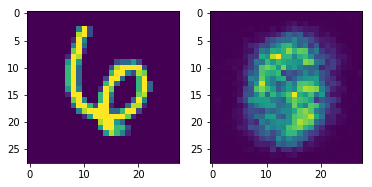

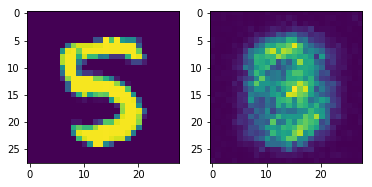

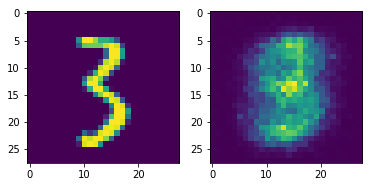

In [42]:

import os
load_model = False
if load_model:
    saver.restore(sess, os.path.join(os.getcwd(), "Trained Bernoulli VAE"))

num_pairs = 10
image_indices = np.random.randint(0, 200, num_pairs)
#Lets plot 10 digits
for pair in range(num_pairs):
    #reshaping to show original test image
    x = np.reshape(mnist.test.images[image_indices[pair]], (1,flattened_size))
    plt.figure()
    x_image = np.reshape(x, (28,28))
    plt.subplot(121)
    plt.imshow(x_image)
    #reconstructed image, feed the test image to the decoder
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    #reshape it to 28x28 pixels
    x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
    #plot it!
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)